In [1]:
! pip install transformers datasets

     |████████████████████████████████| 2.6 MB 7.6 MB/s 
     |████████████████████████████████| 542 kB 59.6 MB/s 
     |████████████████████████████████| 895 kB 53.7 MB/s 
     |████████████████████████████████| 636 kB 67.9 MB/s 
     |████████████████████████████████| 3.3 MB 58.8 MB/s 
     |████████████████████████████████| 76 kB 5.7 MB/s 
     |████████████████████████████████| 243 kB 68.9 MB/s 
     |████████████████████████████████| 118 kB 75.9 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
! sudo apt install tesseract-ocr
! pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,975 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [3]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/kuw05qmc4uy474d/RVL_CDIP_one_example_per_class.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

In [4]:
from google.colab import files
upload = files.upload()

Saving table.png to table.png


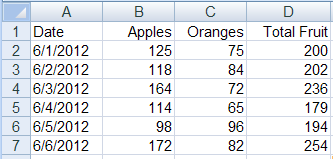

In [5]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("table.png")
image = image.convert("RGB")
image

In [6]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

'A B Cc D “1 Date Apples Oranges Total Fruit 26/1/2012 125 75 200 3 6/2/2012 118 84 202 4 6/3/2012 164 72 236 5 6/4/2012 114 65 179 “6 6/5/2012 98 96 194 “7 662012 172 82 254'

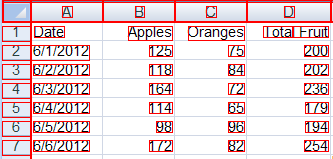

In [7]:
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
    x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
    actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
    actual_boxes.append(actual_box)

draw = ImageDraw.Draw(image, "RGB")
for box in actual_boxes:
  draw.rectangle(box, outline='red')

image

In [21]:
images = []
labels = []

for label_folder, _, file_names in os.walk(dataset_path):
  if label_folder != dataset_path:
    label = label_folder[40:]
    for _, _, image_names in os.walk(label_folder):
      relative_image_names = []
      for image in image_names:
        relative_image_names.append(dataset_path + "/" + label + "/" + image)
      images.extend(relative_image_names)
      labels.extend([label] * len (relative_image_names)) 

data = pd.DataFrame.from_dict({'image_path': images, 'label': labels})
data.head()

,image_path,label


In [10]:
len(data)

15

In [11]:
from datasets import Dataset

def normalize_box(box, width, height):
     return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]

def apply_ocr(example):
        # get the image
        image = Image.open(example['image_path'])

        width, height = image.size
        
        # apply ocr to the image 
        ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
        float_cols = ocr_df.select_dtypes('float').columns
        ocr_df = ocr_df.dropna().reset_index(drop=True)
        ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
        ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
        ocr_df = ocr_df.dropna().reset_index(drop=True)

        # get the words and actual (unnormalized) bounding boxes
        #words = [word for word in ocr_df.text if str(word) != 'nan'])
        words = list(ocr_df.text)
        words = [str(w) for w in words]
        coordinates = ocr_df[['left', 'top', 'width', 'height']]
        actual_boxes = []
        for idx, row in coordinates.iterrows():
            x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
            actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
            actual_boxes.append(actual_box)
        
        # normalize the bounding boxes
        boxes = []
        for box in actual_boxes:
            boxes.append(normalize_box(box, width, height))
        
        # add as extra columns 
        assert len(words) == len(boxes)
        example['words'] = words
        example['bbox'] = boxes
        return example

dataset = Dataset.from_pandas(data)
updated_dataset = dataset.map(apply_ocr)

  0%|          | 0/15 [00:00<?, ?ex/s]

In [12]:
from transformers import LayoutLMTokenizer
import torch

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

def encode_example(example, max_seq_length=512, pad_token_box=[0, 0, 0, 0]):
  words = example['words']
  normalized_word_boxes = example['bbox']

  assert len(words) == len(normalized_word_boxes)

  token_boxes = []
  for word, box in zip(words, normalized_word_boxes):
      word_tokens = tokenizer.tokenize(word)
      token_boxes.extend([box] * len(word_tokens))
  
  # Truncation of token_boxes
  special_tokens_count = 2 
  if len(token_boxes) > max_seq_length - special_tokens_count:
      token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
  
  # add bounding boxes of cls + sep tokens
  token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]
  
  encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
  # Padding of token_boxes up the bounding boxes to the sequence length.
  input_ids = tokenizer(' '.join(words), truncation=True)["input_ids"]
  padding_length = max_seq_length - len(input_ids)
  token_boxes += [pad_token_box] * padding_length
  encoding['bbox'] = token_boxes
  encoding['label'] = label2idx[example['label']]

  assert len(encoding['input_ids']) == max_seq_length
  assert len(encoding['attention_mask']) == max_seq_length
  assert len(encoding['token_type_ids']) == max_seq_length
  assert len(encoding['bbox']) == max_seq_length

  return encoding

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/170 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/606 [00:00<?, ?B/s]

In [13]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D

# we need to define the features ourselves as the bbox of LayoutLM are an extra feature
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'label': ClassLabel(names=['refuted', 'entailed']),
    'image_path': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})

encoded_dataset = updated_dataset.map(lambda example: encode_example(example), 
                                      features=features)

  0%|          | 0/15 [00:00<?, ?ex/s]

In [14]:
encoded_dataset.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])

In [15]:
dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=1, shuffle=True)
batch = next(iter(dataloader))
batch

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [16]:
tokenizer.decode(batch['input_ids'][0].tolist())

'[CLS] clinical record dag 9005 _. _ page 18 i 2, pulnonary emboli, recent, left apical, left cardiac, left diaphragmatic, right apical, right cardiac and right intermediate lobes. 3. infarcts. recent, right apical, left apical, left cardiac, left diaphragmatic, right cardiac and right intermediate lobes. 4. edema and congestion of all lobes of the lung basal cell hyperplasia, slight 6. acute bronchitis, left apical, left cardiac, left diaphragmatic, right cardiac and right intermediate lobes. 7. bronchopneunonia, recent, left apical, left cardiac, left diaphragmatic, right apical, right cardiac and right intermediate lobes. 8. focal caleification, right diaphragmatic lo > 9. passive congestion of the liver, adrenals, spleen and kidney, advanced comment the dog was on the pmo study in enviro control and was a high nicotine smoker. he had smoked 399 cigarettes in a period of 34 days, the findings in the case were those of thrombi in both auricular appendages of the heart with multiple e

In [17]:
idx2label[batch['label'][0].item()]

'form'

In [18]:
from transformers import LayoutLMForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForSequenceClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(label2idx))
model.to(device)

Downloading:   0%|          | 0.00/453M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForSequenceClassification were not initialized from the model checkpoint 

LayoutLMForSequenceClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
      